In [2]:
# initialize packages
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [188]:
# Load data showing Daily total female births in California, 1959
# Data source: https://www.kaggle.com/datasets/dougcresswell/daily-total-female-births-in-california-1959
df = pd.read_csv("data_1.csv")
print("Our data shape is: {}".format(df.shape))
df.head()

Our data shape is: (365, 2)


,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [189]:
# Some simple column editing
df.rename({'Date':'date', 'Births':'y'}, axis='columns', inplace=True)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['date'] = df['date'].dt.date 
df.head()

,date,y
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


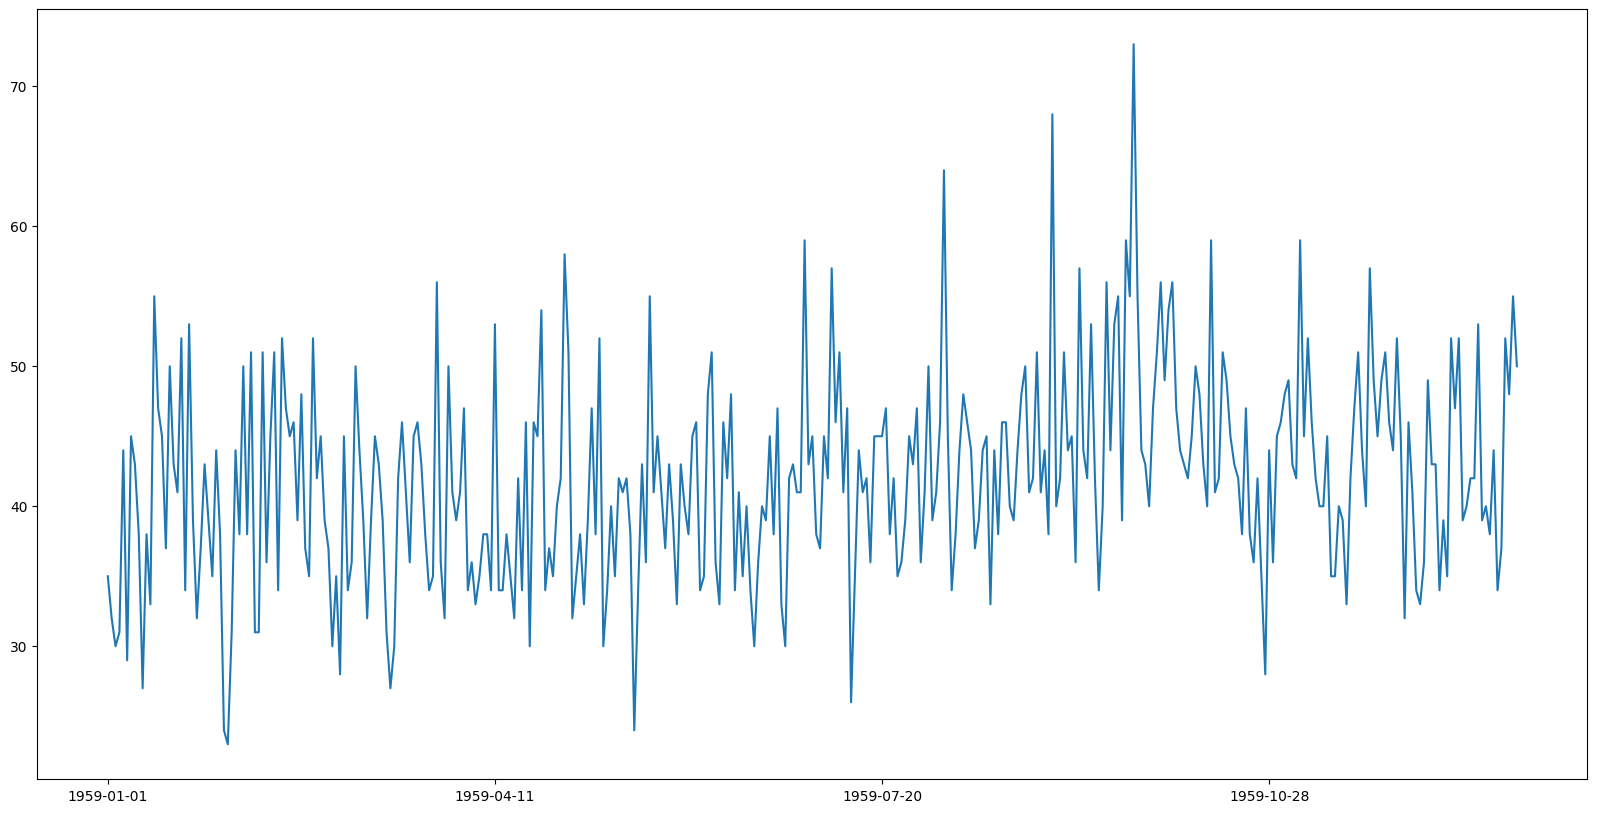

In [190]:
#plot data
# plots 
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(nrows=1, ncols=1)

ax0 = fig.add_subplot(gs[0, :])

ax0.plot(df.y)
ax0.set_xticks(np.arange(0,len(df.y),100))                                                       # display every 10-th tick
ax0.set_xticklabels(df.date[np.arange(0,len(df.y),100)],rotation=0);

Transform the time series into a supervised learning problem
The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.
For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

In [192]:
new_df = pd.DataFrame(df.y)
new_df['x'] = new_df.y.shift()
new_df.fillna(0, inplace=True)
new_df

,y,x
0,35,0.0
1,32,35.0
2,30,32.0
3,31,30.0
4,44,31.0
...,...,...
360,37,34.0
361,52,37.0
362,48,52.0
363,55,48.0


In [193]:
# To make the time series stationary, I will difference the data
Y = np.asarray(new_df.y)
X = np.asarray(new_df.x)
y = (100*(Y[1:Y.size]/Y[0:Y.size-1]-1)) 
x = (100*(X[1:X.size]/X[0:X.size-1]-1))

# remove infinity from x
x[0] = 0

Reserve the first 80% of the stationary series for estimation

In [194]:
# reserve first 80%
y_estimation = y[0:round(0.8*len(y))]
x_estimation = x[0:round(0.8*len(y))]

y_test = y[round(0.8*len(y)):]
x_test = x[round(0.8*len(y)):]

print("Size of y for estimation: {0}".format(len(y_estimation)))
print("Size of x for estimation: {0}".format(len(x_estimation)))
print("\n")
print("Size of y for test: {0}".format(len(y_test)))
print("Size of x for test: {0}".format(len(x_test)))

Size of y for estimation: 291
Size of x for estimation: 291


Size of y for test: 73
Size of x for test: 73


In [195]:
# Transform data to remove heteroscedasticity
y_estimation = np.cbrt(y_estimation)
y_test = np.cbrt(y_test)

x_estimation = np.cbrt(x_estimation)
x_test = np.cbrt(x_test)

In [295]:
# Load packages for Neural Network

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.activations as activation
from keras.layers import Bidirectional

In [274]:
# fit an LSTM network to training data
def fit_lstm(train_x, train_y, batch_size, nb_epoch, neurons):
    
    train_x = train_x.reshape(train_x.shape[0], 1, 1)
    # Use the Sequential Keras API to define the network
    model = Sequential()
    # The line below creates a single LSTM hidden layer that also specifies the expectations of the input layer via the “batch_input_shape” argument.
    model.add(LSTM(neurons, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True, activation=activation.relu))
    model.add(Dense(1))
    # In compiling the network, we will use “mean_squared_error” as the loss function as it closely matches RMSE that we will are interested in, 
    # and the efficient ADAM optimization algorithm.
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Once compiled, it fit to the training data
    model.fit(train_x, train_y, epochs=nb_epoch, batch_size=batch_size, verbose=2, shuffle=False)
    
    return model

In [290]:
import random

random.seed(123)
lstm_model = fit_lstm(x_estimation, y_estimation, 1, 3000, 4)

Epoch 1/3000
291/291 - 2s - loss: 5.8405 - 2s/epoch - 6ms/step
Epoch 2/3000
291/291 - 0s - loss: 5.3882 - 345ms/epoch - 1ms/step
Epoch 3/3000
291/291 - 0s - loss: 5.2396 - 364ms/epoch - 1ms/step
Epoch 4/3000
291/291 - 0s - loss: 5.2091 - 400ms/epoch - 1ms/step
Epoch 5/3000
291/291 - 0s - loss: 5.1796 - 332ms/epoch - 1ms/step
Epoch 6/3000
291/291 - 0s - loss: 5.1625 - 324ms/epoch - 1ms/step
Epoch 7/3000
291/291 - 0s - loss: 5.1465 - 295ms/epoch - 1ms/step
Epoch 8/3000
291/291 - 0s - loss: 5.1363 - 295ms/epoch - 1ms/step
Epoch 9/3000
291/291 - 0s - loss: 5.1284 - 293ms/epoch - 1ms/step
Epoch 10/3000
291/291 - 0s - loss: 5.1230 - 293ms/epoch - 1ms/step
Epoch 11/3000
291/291 - 0s - loss: 5.1181 - 297ms/epoch - 1ms/step
Epoch 12/3000
291/291 - 0s - loss: 5.1119 - 294ms/epoch - 1ms/step
Epoch 13/3000
291/291 - 0s - loss: 5.1051 - 327ms/epoch - 1ms/step
Epoch 14/3000
291/291 - 0s - loss: 5.0980 - 305ms/epoch - 1ms/step
Epoch 15/3000
291/291 - 0s - loss: 5.0901 - 322ms/epoch - 1ms/step
Epoch 1

In [283]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    """_summary_
    Given a fit model, a batch-size used when fitting the model (1), and a row from the test data, 
    the function will separate out the input data from the test row, reshape it, 
    and return the prediction as a single floating point value.
    """
    X = X.reshape(1, 1, 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

I will now fit the model once on all of the training data, then predict each new time step one at a time from the test data

In [292]:
predictions = []

for i in range(len(x_test)):
    x_os = x_test[i]
    y_os = y_test[i]
    
    yhat = forecast_lstm(lstm_model, 1, x_os)
    predictions.append(yhat)
    
    expected = y_os
    print('Predicted={0}, Expected={1}'.format(yhat, expected))

1/1 [==============================] - 0s 26ms/step
Predicted=-0.7600879669189453, Expected=-1.3248819442174429
1/1 [==============================] - 0s 23ms/step
Predicted=-0.40991687774658203, Expected=-2.119679665896653
1/1 [==============================] - 0s 21ms/step
Predicted=0.28568780422210693, Expected=2.8717919311756686
1/1 [==============================] - 0s 23ms/step
Predicted=-1.1992026567459106, Expected=-2.6753558170044154
1/1 [==============================] - 0s 22ms/step
Predicted=0.25441157817840576, Expected=-1.7394640854894958
1/1 [==============================] - 0s 24ms/step
Predicted=1.2161881923675537, Expected=2.5543647746451774
1/1 [==============================] - 0s 22ms/step
Predicted=-0.417291522026062, Expected=-2.554364774645177
1/1 [==============================] - 0s 25ms/step
Predicted=1.006108283996582, Expected=-2.7144176165949063
1/1 [==============================] - 0s 24ms/step
Predicted=1.9275763034820557, Expected=3.8517135711083577
1

In [293]:
# evaluate forecasts
rmse = sm.tools.eval_measures.rmse(y_test, predictions)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.111


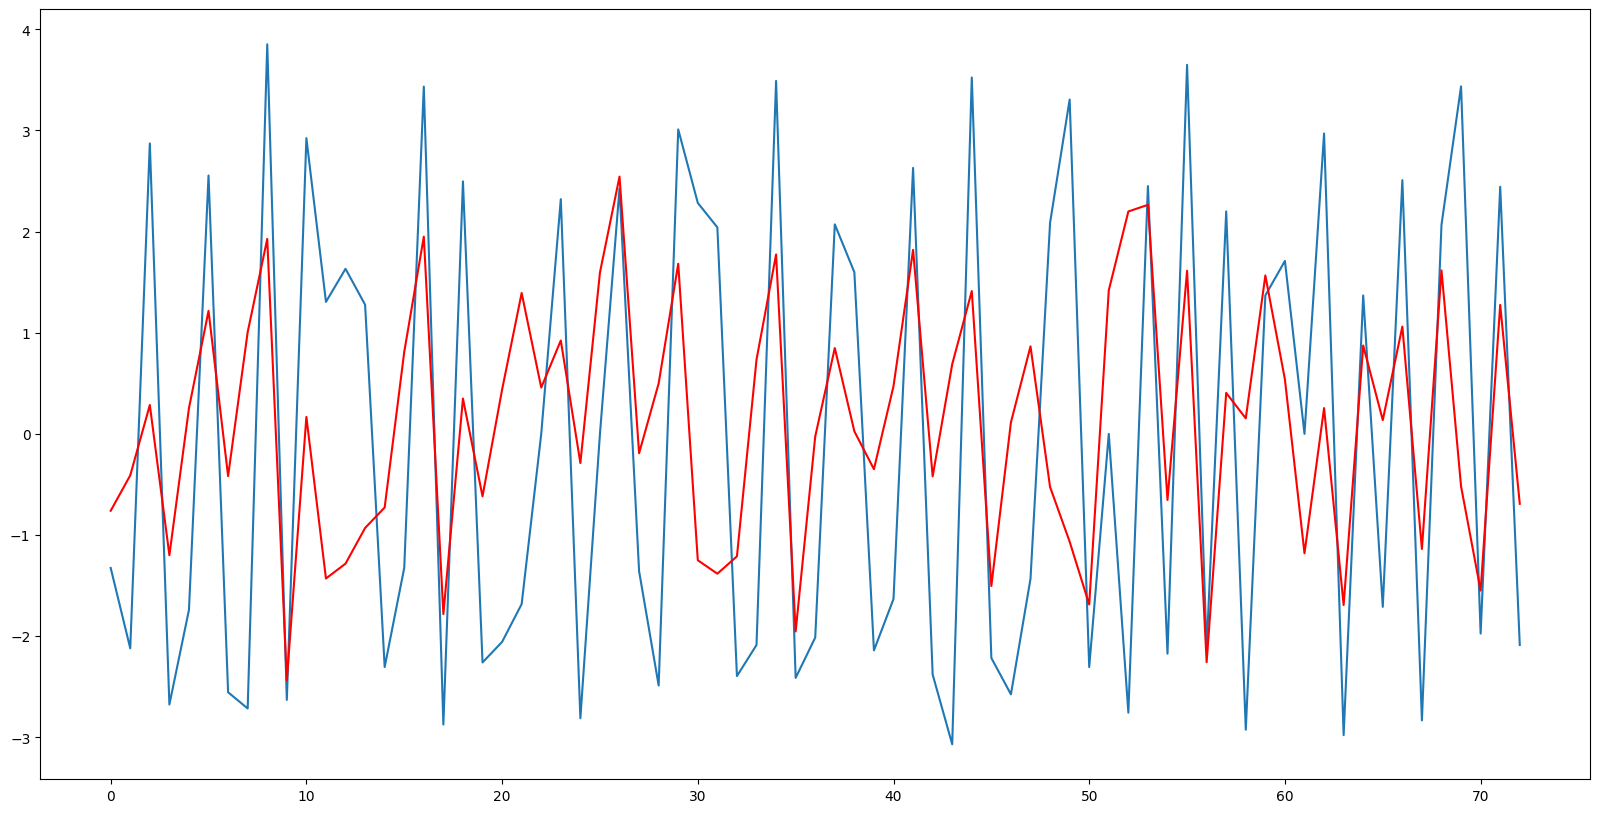

In [294]:
# plot forecasts against actual outcomes
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(nrows=1, ncols=1)

ax0 = fig.add_subplot(gs[0, :])
ax0.plot(y_test)
ax0.plot(predictions, color='red')
plt.show()

I will now try updating the model at each time step of the test data as new observations from the test data are made available. This is basically 1 step ahead forecast. Example: assume you have 100 observations. 1st one-step-ahead forecast: Estimate the model on T = 1...80 and forecast the value for T=81. 2nd one-step-ahead forecast: Estimate the model on T = 1...81 and forecast T=82, etc..  

In [296]:
# I fit an LSTM network to training data
# On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.
# I will do this using a Bidirectional LSTM.

# I use a Bidirectional LSTM because the normal LSTM doesn't perform well when trying one step ahead forecast

def fit_lstm(train_x, train_y, batch_size, nb_epoch, neurons):
    
    train_x = train_x.reshape(train_x.shape[0], 1, 1)
    
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), return_sequences=True, activation=activation.relu)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.fit(train_x, train_y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    
    return model

In [297]:
import random

predictions = []

history_x = [i for i in x_estimation]
history_y = [j for j in y_estimation]

for i in range(len(x_test)):
    x_est = np.array(history_x)
    y_est = np.array(history_y)
    
    random.seed(123)
    lstm_model = fit_lstm(x_est, y_est, 1, 10, 4)
    
    x_os = x_test[i]
    y_os = y_test[i]
    
    yhat = forecast_lstm(lstm_model, 1, x_os)[0]
    predictions.append(yhat)
    
    history_x.append(x_os)
    history_y.append(y_os)
    
    expected = y_os
    print('Predicted={0}, Expected={1}'.format(yhat, expected))

1/1 [==============================] - 0s 392ms/step
Predicted=0.6745237708091736, Expected=-1.3248819442174429
1/1 [==============================] - 0s 461ms/step
Predicted=0.5366724729537964, Expected=-2.119679665896653
1/1 [==============================] - 0s 362ms/step
Predicted=0.8581643104553223, Expected=2.8717919311756686
1/1 [==============================] - 0s 473ms/step
Predicted=-1.0912126302719116, Expected=-2.6753558170044154
1/1 [==============================] - 0s 479ms/step
Predicted=1.1163113117218018, Expected=-1.7394640854894958
1/1 [==============================] - 0s 381ms/step
Predicted=0.6860761642456055, Expected=2.5543647746451774
1/1 [==============================] - 0s 454ms/step
Predicted=-0.943311333656311, Expected=-2.554364774645177
1/1 [==============================] - 0s 384ms/step
Predicted=1.0429658889770508, Expected=-2.7144176165949063
1/1 [==============================] - 0s 363ms/step
Predicted=1.0902327299118042, Expected=3.8517135711083

Test RMSE: 2.175


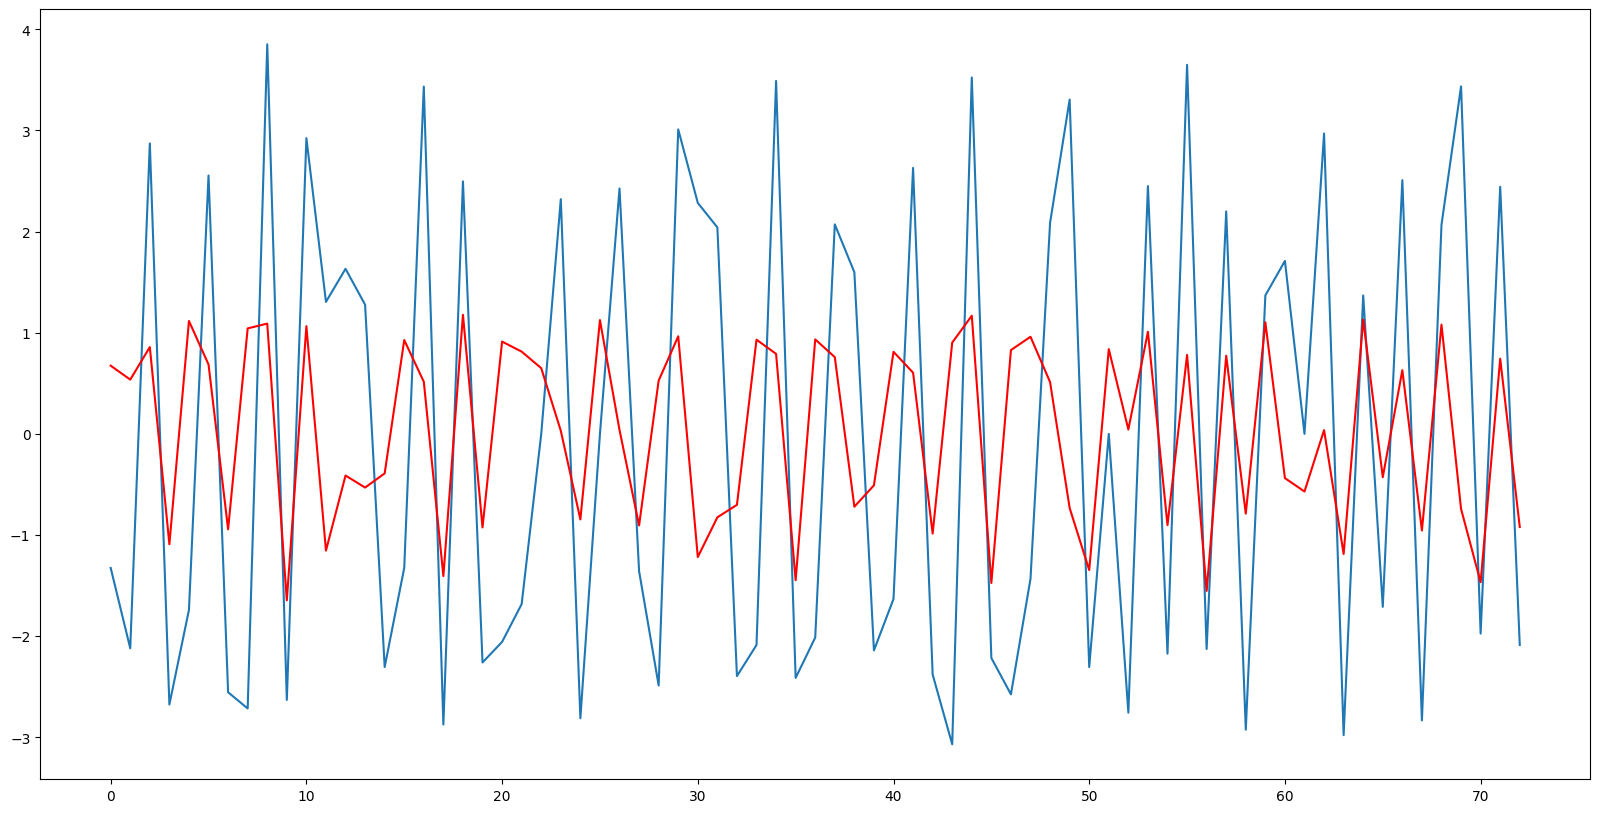

In [298]:
# evaluate forecasts
rmse = sm.tools.eval_measures.rmse(y_test, predictions)
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(nrows=1, ncols=1)

ax0 = fig.add_subplot(gs[0, :])
ax0.plot(y_test)
ax0.plot(predictions, color='red')
plt.show()

# This method of forecasting doesn't do as well.